# **I. Project Description**

- Cookie Cats is a popular mobile puzzle game where players match tiles to clear levels.

- As players progress, they sometimes hit gates that require them to wait or make a purchase to continue. These gates are meant to encourage breaks and increase enjoyment.

- The first gate was originally at level 30, but in this test, we moved it to level 40. We’ll now look at how this change affects all metrics. Let’s check it out!

# **II. Data Description**


In [33]:
import pandas as pd

df = pd.read_csv('cookie_cats.csv')

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


The data comes from 90,189 players who installed the game during the A/B test. The variables are:

- userid: A unique ID for each player.

- version: Whether the player was in the control group (gate_30) or test group (gate_40)

- sum_gamerounds: The number of rounds played in the first week.

- retention_1: Whether the player returned 1 day after installation.

- retention_7: Whether the player returned 7 days after installation.

Players were randomly assigned to either gate_30 or gate_40 when they installed the game.

# **III. Check data size**

In [35]:
df.groupby('version')['userid'].nunique().reset_index(name='userid')

,version,userid
0,gate_30,44700
1,gate_40,45489


Out of 90,189 records, about half are using the gate_30 version (Group A) and the other half are using the gate_40 version (Group B).

Great, we can now proceed with the analysis.

# **IV. A/B Testing Evaluate**

## 1.Metric : sum_gamerounds

### a.Game_rounds Overall

Text(0, 0.5, 'userid')

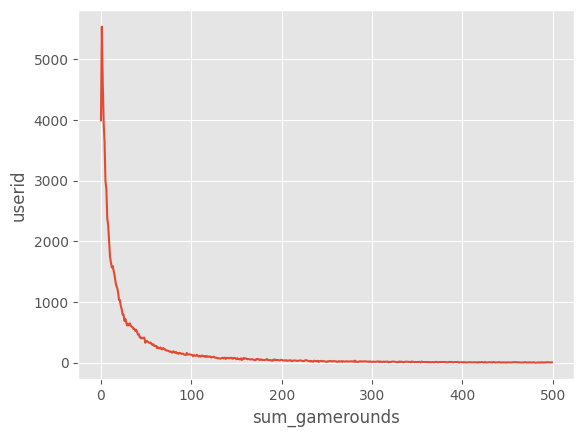

In [36]:
%matplotlib inline

plot_df = df.groupby ('sum_gamerounds') ['userid'].nunique()

ax = plot_df.head (500).plot ()
ax.set_xlabel("sum_gamerounds")
ax.set_ylabel("userid")

*Comment* :

*It appears that the vast majority of users are playing less than 20 rounds in total, over the recording of this data.*

*Let’s take the same approach to see if there is much of a difference in the number of games played in our AB versions allotted to each user.*

### b.Game_rounds by A/B test

**Descriptive Statistics**

<ipython-input-37-f03400b27878>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A["sum_gamerounds"], bins=bins)).count())
<ipython-input-37-f03400b27878>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B["sum_gamerounds"], bins=bins)).count())


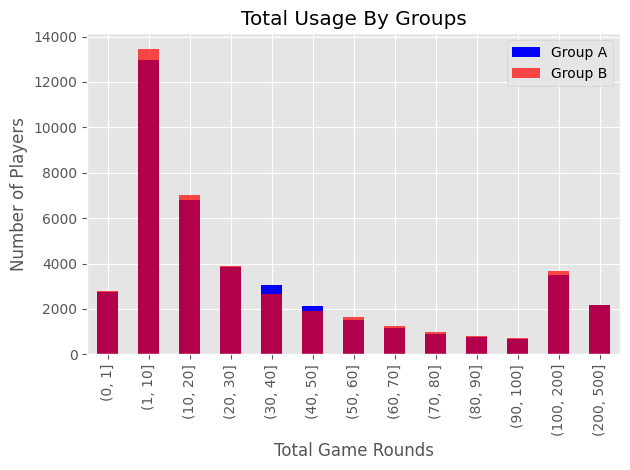

In [37]:
import pandas as pd
import io
import matplotlib.pyplot as plt

plt.style.use('ggplot')

# Counting the number of players for each number of gamerounds
Group_A = df[df.version == 'gate_30']
Group_B = df[df.version == 'gate_40']

bins = [0,1,10,20,30,40,50,60,70,80,90,100,200,500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A["sum_gamerounds"], bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B["sum_gamerounds"], bins=bins)).count())


# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_GA[:50].plot(kind = 'bar', y="userid", color = "blue", alpha = 1,
                       title = 'Total Usage By Groups')
plot_GB[:50].plot(kind = 'bar', y="userid", ax=ax, color = "red", alpha = 0.7 )
ax.set_xlabel("Total Game Rounds")
ax.set_ylabel("Number of Players")
plt.legend(["Group A", "Group B"])
plt.tight_layout()
plt.grid(True)

*Comment :*
*There doesn’t seem to be a large difference between the two versions overall. However, there does seem to be some slight disparities around the (1,10] , (30-40], (50,60] range that may be related to the AB test at hand*

**Inference Statistic**

Use the 2-sample mean test to evaluate whether the sum_gamerounds of 2 gates_30 and gate_40 are significant.

A/B Testing Hypothesis:

H0: A == B: There is no statistical difference between the sum_gamerounds of the gate_30 and the gate_40

H1: A != B: There is statistical difference between the sum_gamerounds ofthe gate_30 and the gate_40

In [38]:
from scipy.stats import shapiro
from scipy import stats
import numpy as np

# A/B testing function for continuous variables
def AB_test_continuous(dataframe, group, target, A, B):
    # packages (already imported above)
    # from scipy.stats import shapiro
    # import scipy.stats as stats

    # split A/B
    groupA = dataframe[dataframe[group] == A][target]
    groupB = dataframe[dataframe[group] == B][target]

    # assumption: normality
    ntA = shapiro(groupA)[1] < 0.05 # -> reject H0
    ntB = shapiro(groupB)[1] < 0.05
        # H0: Distribution is normal - False
        # H1: Distribution is not normal - True
    if (ntA == False)&(ntB == False):
        # parametric test
        # assumption: homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
            # H0: Homogeneity - False
            # H1: Heterogeneous - True
        if leveneTest == False:
            # homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
        else:
            # heterogenerous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
                # H0: M1 == M2 - False
                # H1: M1 != M2 - True
    else:
        # non-parametric test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    # result
    temp = pd.DataFrame({
        'AB Hypothesis': [ttest < 0.05],
        'p-value':[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    # columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type", "AB Hypothesis", "p-value", "Comment"]]
    # print hypothesis
    print("A/B Testing Hypothesis:")
    print("H0: A == B")
    print("H1: A != B", "\n")
    return temp

In [39]:
AB_test_continuous(dataframe=df, group='version', target='sum_gamerounds', A='gate_30', B='gate_40')

A/B Testing Hypothesis:
H0: A == B
H1: A != B 



/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 44700.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45489.
  res = hypotest_fun_out(*samples, **kwds)


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050209,A/B groups are similar!


*Comment* :

*Since the p-value is greater than 0.05, we fail to reject the Null Hypothesis, meaning there is not enough evidence to conclude that there is a significant difference between the two groups.*

=> *The difference between the groups is not statistically significant. Therefore, we cannot confirm that one group (gate_30 or gate_40) is more effective than the other.*


##2.Metric : %Retention_1

We want players to enjoy the game and keep playing. A common metric for engagement is 1-day retention, which is the percentage of players who return one day after installing the game. Higher 1-day retention makes it easier to retain players and grow the player base.


### a.1-Day Retention Overall

In [40]:
print('%Retention_1 : ', round(df[df['retention_1'] == True]['userid'].nunique() /df['userid'].nunique() *100,4))

%Retention_1 :  44.521


### b.1-Day Retention by A/B test

**Descriptive Statistics**

In [41]:
userid_count1 = df.groupby('version')['userid'].nunique().reset_index(name='userid')
userid_r1_count1 = df[df['retention_1'] == True].groupby('version')['userid'].nunique().reset_index(name='userid_r1')
result1 = pd.merge(userid_count1, userid_r1_count1, on='version', how='left')
result1['%r1'] = (result1['userid_r1'] / result1['userid']) * 100
result1 = result1.fillna(0)

result1

,version,userid,userid_r1,%r1
0,gate_30,44700,20034,44.818792
1,gate_40,45489,20119,44.228275


*Comment* :

*Retention rate 1D at gate_30 and gate_40 fluctuates around 44% , similar to the overall retention rate.*

*However there is a difference of 0.6% loss at gate_40
compared to between gate_30*


**Inference Statistic**

In [42]:
import math
import numpy as np
import pandas as pd
from scipy import stats

from IPython.display import display, Markdown

def ZTestProportion(p1, n1, p2=None, n2=None, A=0, alternative='!=', alpha=0.05):
    def compute_pvalue(testStat, distribution, alternative):
        if alternative in ['two-sided', '2s', 'other than', '!=']:
            signH1 = '!='
            pValue = distribution.sf(np.abs(testStat)) * 2
        elif alternative in ['larger', 'right', 'greater', '>']:
            signH1 = '>'
            pValue = distribution.sf(testStat)
        elif alternative in ['smaller', 'less', 'left', '<']:
            signH1 = '<'
            pValue = distribution.cdf(testStat)
        return signH1, pValue

    def process_decision(pValue, alpha):
        if pValue <= alpha:
            signTest = '<'
            mess = 'reject Null Hypothesis'
        elif pValue > alpha:
            signTest = '>'
            mess = 'fail to reject Null Hypothesis'
        return signTest, mess

    # compute x2 statistics
    if p2 is not None and n2 is not None:
        objective = 'p1 - p2'
    elif p2 is None and n2 is None:
        p2, n2 = 0, np.inf
        objective = 'p'

    se = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    testStat = (p1-p2-A) / se
    signH1, pValue = compute_pvalue(testStat, stats.norm, alternative)
    signTest, mess = process_decision(pValue, alpha)

    print(
        f'Alternative Hypothesis: {objective} {signH1} {A}' '\n'
        f'p-value = {pValue:.4f} {signTest} {alpha} --> {mess}'
    )

A/B Testing Hypothesis:

H0: There is no statistical difference in Day 1 retention rate between gate_30 and gate_40.

H1: There is a statistical difference in Day 1 retention rate between gate_30 and gate_40.

In [43]:
ZTestProportion(p1 = 20034/44700, n1 = 44700, p2=20119/45489, n2=45489, A=0, alternative='!=', alpha=0.05)

Alternative Hypothesis: p1 - p2 != 0
p-value = 0.0744 > 0.05 --> fail to reject Null Hypothesis


*Comment :*

*Since the p-value is greater than 0.05, we fail to reject the Null Hypothesis, meaning there is not enough evidence to support a significant difference between the two groups. This suggests that the observed difference between the groups is likely due to random chance, and we cannot conclude that one group (gate_30 or gate_40)  performs better than the other based on this data.*


##3.Metric : %Retention_7

If players only play the game for one day, it is likely that most players have not yet reached level 30. That is, many players will not be affected by the portal, even if they only reach level 30.

But after playing for a week, many more players will reach level 40, so it makes sense to look at the 7-day retention rate. That is: What percentage of people who installed the game also showed up a week later to play the game again.

Let's start by calculating the 7-day retention rate for the two AB groups.

### a. 7-Day Retention Overall

In [44]:
print('%Retention_7 : ', round(df[df['retention_7'] == True]['userid'].nunique() /df['userid'].nunique() *100,4))

%Retention_7 :  18.6065


### b.7-Day Retention by A/B test

**Descriptive Statistics**

In [45]:
userid_count2 = df.groupby('version')['userid'].nunique().reset_index(name='userid')
userid_r7_count2 = df[df['retention_7'] == True].groupby('version')['userid'].nunique().reset_index(name='userid_r7')
result2 = pd.merge(userid_count2, userid_r7_count2, on='version', how='left')
result2['%r7'] = (result2['userid_r7'] / result2['userid']) * 100
result2 = result2.fillna(0)

result2

,version,userid,userid_r7,%r7
0,gate_30,44700,8502,19.020134
1,gate_40,45489,8279,18.200004


*Comment : 7-day retention is slightly lower (18.2%) when the gate is at level 40 compared to level 30 (19.0%). This difference is more noticeable for 7-day retention, likely because more players have had time to reach the first gate.*

**Inference Statistic**

A/B Testing Hypothesis:

H0: There is no statistical difference in Day 7 retention rate between gate_30 and gate_40.

H1: There is a statistical difference in Day 7 retention rate between gate_30 and gate_40.

In [46]:
ZTestProportion(p1 = 8502/44700, n1 = 44700, p2=8279/45489, n2=45489, A=0, alternative='!=', alpha=0.05)

Alternative Hypothesis: p1 - p2 != 0
p-value = 0.0016 < 0.05 --> reject Null Hypothesis


*Comment :*

*Since the p-value is less than 0.05, we reject the Null Hypothesis, meaning there is enough evidence to support a significant difference between the two groups. This suggests that the observed difference between the groups is not due to random chance, and we can conclude that gate_30 performs significantly better than gate_40 based on this data.*


#The Conclusion

**After applying A/B Testing, the results gives us some important information:**

- The Mann Whitney U test failed to reject H0 hypothesis and we learned that A/B groups are similar. Therefore, there's no statistically significant difference in number of game rounds between version gate_30 and gate_40.
- The Chi Square test's results helped us learn that version gate_30 and gate_40 are similar in term of retention_1 but are statistically different in term of retention_7. The retention_7 rate of version gate_40 is 14,92% that is lower than 15,76% of version gate_30.

**Hence, we should keep the old version.**

- This outcome suggests that changing the first gate from level 30 to level 40 may not influence number of game rounds and retention 1 day after installing. However, the retention rates 7 day after installing after the change decreased which is counter-intuitive.
- It's essential to continue to consider other potential factors that may influence player behavior, such as the overall game experience, the presence of alternative options, and the quality of in-game rewards.